In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
df = pd.read_csv("../input/creditcard.csv")
df =  shuffle(df).reset_index(drop=True)
df.head()

creditcard.csv



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,47925.0,-2.490287,-0.260394,1.853891,1.899267,0.853351,-0.727073,-0.200017,0.655494,-1.106321,...,-0.108057,-0.474958,0.583079,0.480543,0.220761,-0.355668,-0.125249,-0.047782,0.76,0
1,123650.0,2.209234,-0.587293,-1.297078,-0.905872,-0.430848,-1.199709,-0.264311,-0.435359,-0.762956,...,0.466216,1.387952,0.051267,1.241763,0.217157,0.005462,-0.035367,-0.051918,15.00,0
2,163095.0,-0.863708,0.560844,-2.323066,-1.375420,3.749304,2.836620,0.635449,0.578432,-0.254691,...,0.112690,0.427050,-0.282438,0.662331,-0.816610,0.147977,-0.606641,-0.275724,18.00,0
3,167849.0,0.281468,0.540924,-2.042245,-0.254178,1.174166,0.171534,0.157435,-2.986427,-0.776229,...,-0.967411,1.027021,-0.467020,-1.402770,0.713737,-0.292521,0.154864,0.331082,153.93,0
4,33519.0,1.343807,-0.490272,0.427164,-0.708862,-0.863968,-0.616625,-0.526628,-0.098927,-0.859735,...,-0.008992,-0.128651,0.105547,0.075944,0.239893,-0.391537,0.019747,0.019125,22.95,0


In [3]:
frac =0.80 
X_train = df.sample(frac=frac)
count_FRAUDE = len(X_train)

#X_test contains all the transaction not in X_train.
X_test = df.loc[~df.index.isin(X_train.index)].reset_index(drop=True).astype(float)

#Add our target features to y_train and y_test.
y_train = pd.DataFrame({'Class':X_train.Class.reset_index(drop=True)})



y_test = pd.DataFrame({'Class':X_test.Class.reset_index(drop=True)})

#Drop target features from predictors X_train and X_test.
X_train = X_train.drop(['Class'], axis = 1).reset_index(drop=True)
X_test = X_test.drop(['Class'], axis = 1).reset_index(drop=True)


In [4]:
features = X_train.columns.values
for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std


In [5]:
nrow = len(X_train)
depthList = np.array(range(1,20)) #search depth list
xvalMSE =[]
epoch = 1
score_history =[]
for iDepth in depthList:

    for ixval in range(epoch):

        xTrain = X_train.as_matrix()
        yTrain = y_train.as_matrix().ravel()
        xTest = X_test.as_matrix()
        yTest = y_test.as_matrix().ravel()

    
        treeModel = DecisionTreeClassifier(max_depth = iDepth)
        treeModel.fit(xTrain, yTrain)
        
        treePrediction = treeModel.predict(xTest)
        treePrediction=np.array(treePrediction,dtype=np.float32)
        yTest = np.array(yTest,dtype=np.float32)
        
        error = [yTest[r] - treePrediction[r] for r in range(len(yTest))]

        
        if ixval == 0:
            oosErrors = sum([e*e for e in error])
        else:
            oosErrors += sum([e*e for e in error])
    score = roc_auc_score(yTest, treePrediction)
    score_history.append(score)    
    mse = oosErrors/nrow
    xvalMSE.append(mse)

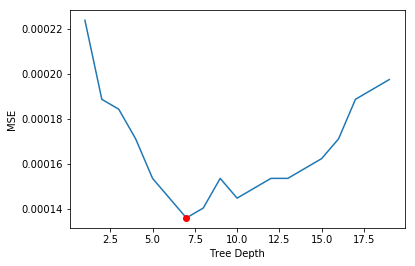

In [6]:
plt.figure()
plt.plot(depthList,xvalMSE)
plt.axis("tight")
plt.xlabel("Tree Depth")
plt.ylabel("MSE")
opt_depth = depthList[np.argmin(xvalMSE)]
plt.plot(opt_depth,np.amin(xvalMSE),"or")

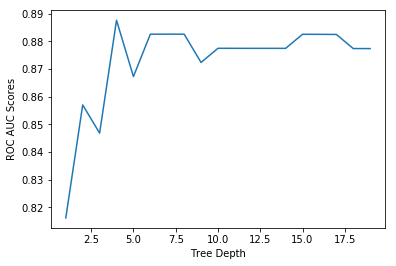

In [7]:
plt.figure()
plt.plot(depthList,score_history)
plt.axis("tight")
plt.xlabel("Tree Depth")
plt.ylabel("ROC AUC Scores")
plt.show()

In [8]:
print("Minimum MSE:",np.amin(xvalMSE))
print("Maximum ROC AUC Score:", np.amax(score_history))

Minimum MSE: 0.000136056810302
Maximum ROC AUC Score: 0.887605619952
